In [1]:
import os
import astropy.table

In [2]:
CATSIM_CATALOG_PATH = "/sps/lsst/users/bbiswas/OneDegSq.fits"

_, ext = os.path.splitext(CATSIM_CATALOG_PATH)
fmt = "fits" if ext.lower() == ".fits" else "ascii.basic"
catalog = astropy.table.Table.read(CATSIM_CATALOG_PATH, format=fmt)

In [3]:
catalog

galtileid,ra,dec,redshift,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,a_b,a_d,b_b,b_d,pa_bulge,pa_disk,u_ab,g_ab,r_ab,i_ab,z_ab,y_ab
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2200871446,0.418319702147,-0.000148399994941,0.496377289295,0.0,1.4144730572e-17,0.0,0.0,0.278649687767,0.0,0.221303001046,0.0,307.344329834,25.9418621063,25.129743576,23.9588813782,23.3607368469,23.0723800659,22.9095973969
2205921112,0.420028448104,-0.00100259995088,1.89508104324,0.0,1.91501907101e-18,0.0,0.0,0.358063697815,0.0,0.313674807549,0.0,137.791702271,25.848903656,25.867565155,25.9179477692,25.9851398468,25.8779563904,25.7642536163
2205010878,0.423432350157,-0.00312969996594,1.93795013428,0.0,2.15612608955e-18,0.0,0.0,0.444279909134,0.0,0.424689114094,0.0,233.972427368,25.5657653809,25.5659580231,25.6165962219,25.6957893372,25.6281528473,25.5399188995
2208734677,0.42108619213,-7.25999998394e-05,1.16251754761,0.0,1.74001598433e-18,0.0,0.0,0.312852591276,0.0,0.180962398648,0.0,217.517120361,27.3159255981,27.4167633057,27.051820755,26.6737632751,25.9380722046,25.6458129883
2212241881,0.423181056976,-0.00218109996058,1.35479903221,0.0,1.11031595423e-18,0.0,0.0,0.414316505194,0.0,0.205554202199,0.0,226.523849487,27.3325939178,27.4470024109,27.3282527924,27.0680370331,26.7419490814,26.1817016602
2204477290,0.422583341599,-0.000604000000749,1.33114361763,0.0,5.75775484903e-18,0.0,0.0,0.351797997952,0.0,0.126827403903,0.0,53.955165863,25.6527175903,25.7753200531,25.4755821228,25.2793464661,24.9572029114,24.4631252289
2201104165,0.422105312347,-0.00160690001212,0.812159895897,6.57883086866e-18,2.26453001134e-17,0.0,0.22702370584,0.191140606999,0.20540009439,0.0433686003089,24.3779182434,24.3779182434,25.9493045807,25.4186573029,24.5099773407,23.527223587,23.0481529236,22.813867569
2211831084,0.422278761862,-0.00242089992389,1.52316868305,0.0,1.06012697736e-18,0.0,0.0,0.216705903411,0.0,0.123286098242,0.0,13.71824646,27.2072696686,27.268491745,27.2910671234,27.0573310852,26.8970832825,26.4211711884
2213920571,0.428705215453,-0.00933680031449,1.01047706604,0.0,2.24895700248e-19,0.0,0.0,0.229738906026,0.0,0.175429001451,0.0,281.466491699,26.6581230164,26.9268531799,27.170211792,27.3262882233,27.3432483673,27.5143566132


In [4]:
from galcheat.utilities import mag2counts, mean_sky_level
import numpy as np

In [5]:
snr = []
# For calculation of source counts (C) and mean_sky_level (B) refer to https://github.com/aboucaud/galcheat/blob/main/galcheat/utilities.py
# For Computaion of SNR, refer to: https://smtn-002.lsst.io/
B = mean_sky_level("LSST", "r").to_value("electron")
g = 2.3
sig_instr = 12.7
n_eff = 2.266*((.83/.2)**2)

for row in catalog:
    #print(row['r_ab'])
    C = mag2counts(row['r_ab'], "LSST", "r").to_value("electron")
    snr.append(C / np.sqrt(C + ( B/g + sig_instr**2 ) * n_eff))

In [6]:
snr = np.array(snr)

In [7]:
import matplotlib.pyplot as plt

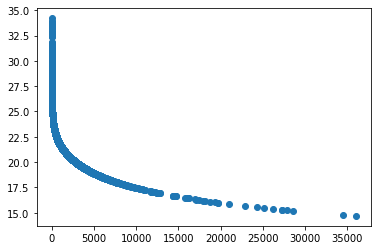

In [20]:
plt.scatter(x=snr, y=catalog["r_ab"])


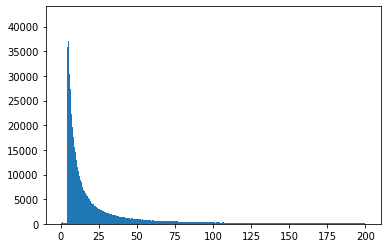

In [10]:
plt.hist(snr[snr<=200], bins=500);

In [12]:
import seaborn as sns

<AxesSubplot:ylabel='r_ab'>

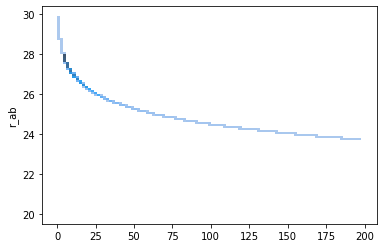

In [13]:
x_bins = np.arange(0,200, 200/100.0)
y_bins = np.arange(20, 30, 10/100.0)

sns.histplot(x=snr, y=catalog["r_ab"], bins=[x_bins, y_bins], kde=True)

In [11]:
frac = np.sum(snr<10)/len(snr)*100
print(f"Percentage below snr 10 : {frac}")

Percentage below snr 10 : 43.505431554032484
